# Feature Engineering
In this exercise, we will take a closer look at feature engineering. It is an essential skill for every data scientist since it gives a great performance boost to the machine learning model, which we will see shortly. Most features can be created by simple tricks or creative thinking and taking a close look at the data.

The exercise is split into four distinct parts. 
* traditional feature engineering, as it is often used in the industry
* using the kernel trick to create some clever features
* feature engineering for images
* advanced feature engineering for stock price data

*Remark:* Although the topic of classification is covered in later lectures, simple classifiers were used in this exercise. However, these are only used to visualize the difference in using feature engineering. Thus you can disregard the code containing classifiers and purely interpret the results.

For this exercise, we will need the `yfinance` package, which is used to retrieve stock price data from yahoo finance. If you do not already have it installed, which is the case for most of you, just run the cell below, and it will install it.

In [1]:
!pip install --upgrade yfinance
!pip install --upgrade scikit-image

In [2]:
import io
import re
import time
import datetime
import requests
import random
import scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.datasets
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import yfinance as yf

from skimage import io
from skimage import data as skimage_data
from skimage.color import rgb2gray

# define our random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Traditional Feature Engineering
In the first part of the exercise, we will look at traditional feature engineering, which means that we will use domain knowledge to create additional relevant features. These features should then increase the predictive powers of a learning algorithm.

We will use the [Titanic Kaggle dataset](https://www.kaggle.com/c/titanic) to showcase the benefits of using feature engineering. This dataset consists of information about the passengers of the Titanic as well as if they have survived. The goal is to predict if a passenger survived or not.

We will create two datasets, the first one is just the raw titanic dataset, with minimal additions such as imputing missing values and so on. And the second one will contain some additional features we created. Then we will train a model on both datasets and compare them on the same test set.

In [3]:
# import the data
df = pd.read_csv('titanic/train.csv')

# store the target variable 
survived = df['Survived']

# drop the target variable
data = df.drop(['Survived'], axis=1)
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Since there are missing values in the dataset, we will first impute them by the median for the `Age` and the `Fare`. For `Embarked` we will fill the missing values by using the mode of the feature, which corresponds to the most frequent value.

In [4]:
# Impute missing values for Age, Fare, Embarked
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Here we copy the original dataset, so that we can then see the difference in performance when using feature engineering.

In [5]:
data_transf = data.copy()

The first feature we will create is the passengers titles, which is available in the `Name`. The title can be seen for example in record 4, _Allen, Mr. William Henry_, where the name also includes his title. We will assume that the title will be beneficial for the algorithm to know, because it could indicate something about their survival in the end.

In [6]:
# extract the titles from the names and add them as a new column
data_transf['Title'] = data_transf['Name'].apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))
data_transf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


We will visualize the frequency of each title in the dataset, to visualy inspect our newly created feature.

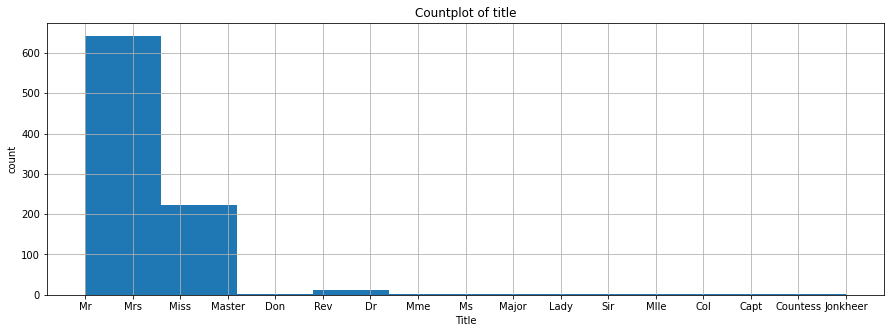

In [7]:
plt.figure(figsize=(15, 5))
data_transf['Title'].hist()
plt.xlabel('Title')
plt.ylabel('count')
plt.title('Countplot of title')
plt.show()

We can see that there are a lot of different titles in the dataset. To make the feature even better, we will combine some of the titles to one title, such as `Mlle` and `Ms` with `Miss`. We can combine them because some of them are the same title but just in a different language. Next, we will also create a bucket for all the other titles, which we will call `Special`, where we then add titles such for example `Major`.

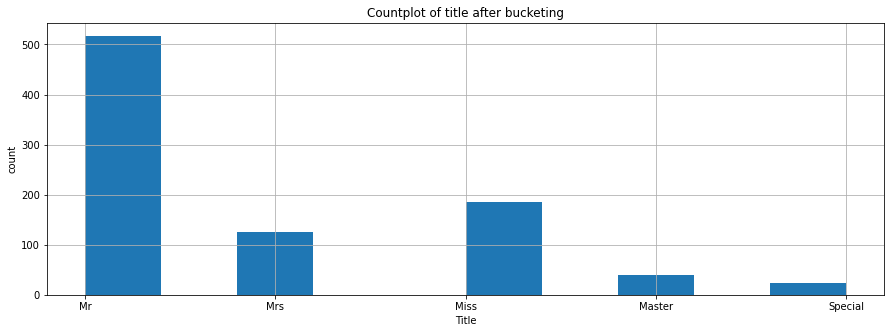

In [8]:
data_transf['Title'] = data_transf['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data_transf['Title'] = data_transf['Title'].replace(['Don', 'Dona', 'Rev', 'Dr', 'Major', 
                                       'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Special')

# plot the titles
plt.figure(figsize=(15, 5))
data_transf['Title'].hist()
plt.xlabel('Title')
plt.ylabel('count')
plt.title('Countplot of title after bucketing')
plt.show()

Since we now have engineered our first feature, we will look at our data again and think of other creative ways of creating some additional features. We can see that the `Cabin` column contains some `NaN` values, which is reasonable since not every passenger on the titanic had a cabin. The information if a passenger had a cabin or not can give us some additional information if they survived or not. Therefore we will create a new feature called `Has_Cabin`, which is `True` if they had a cabin and vice versa.

In [9]:
data_transf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


We will use the `.isnull()` method, which will return `True` if `Cabin` is empty, which means the passenger did not have a cabin. And since we want to know if someone had a cabin or not, we need to flip the result by using tilde `~`.

In [10]:
data_transf['Has_Cabin'] = ~data_transf['Cabin'].isnull()
data_transf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Has_Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


Next, we will drop some of the columns since we won't be using them here in our example. However, there still might be much useful information in them, especially in the `Cabin` column. But for our example, we can discard it.
* `Cabin`, because we already extracted the feature `Has_Cabin`
* `Name`, because we already extracted the feature `Title`
* `PassengerId` and `Ticket`, because they probably do not tell us something about their survival status, since they are both just ID's
* `SibSp` and `Parch` could be used to get the family size, but in our exercise, we will ignore that fact and drop these features

We will drop these columns for both our transformed and our original dataset, to reduce the feature count.

In [11]:
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
data_transf.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
data_transf.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,7.2500,S,Mr,False
1,1,female,38.0,71.2833,C,Mrs,True
2,3,female,26.0,7.9250,S,Miss,False
3,1,female,35.0,53.1000,S,Mrs,True
4,3,male,35.0,8.0500,S,Mr,False


Another important aspect of feature engineering is numerical binning, which means that we will create a fixed amount of bins and then assign the numbers to their corresponding bin. The idea is that often, numerical data without binning them contains many fluctuations and therefore doesn't reflect the actual pattern in the data, because it also contains noise. We will use pandas `.qcut()` method for this and bin our numerical data (`Age` and `Fare`) in four buckets. And since we extracted all the information for both of the features, we can safely drop them.

In [12]:
data_transf['CatAge'] = pd.qcut(data_transf['Age'], q=4, labels=False)
data_transf['CatFare'] = pd.qcut(data_transf['Fare'], q=4, labels=False)

data_transf.drop(['Age', 'Fare'], axis=1, inplace=True)

data_transf.head()

,Pclass,Sex,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,S,Mr,False,0,0
1,1,female,C,Mrs,True,3,3
2,3,female,S,Miss,False,1,1
3,1,female,S,Mrs,True,2,3
4,3,male,S,Mr,False,2,1


Before training our model we need to handle the categorical data in our dataset. We will use `.get_dummies()` from pandas to convert the categorical features to numerical ones. One nice benefit of this function is, that for each categorical feature it will decide if it is more suited to use one hot encoding or label encoding, so that we don't need to think about that.

In [13]:
# we will also do the conversion for the orignial dataset, 
# because otherwise we would't be able to use it
data = pd.get_dummies(data, drop_first=True)

data_transf = pd.get_dummies(data_transf, drop_first=True)
data_transf.head()

,Pclass,Has_Cabin,CatAge,CatFare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,0,1,0,1,0,0
1,1,True,3,3,0,0,0,0,0,1,0
2,3,False,1,1,0,0,1,1,0,0,0
3,1,True,2,3,0,0,1,0,0,1,0
4,3,False,2,1,1,0,1,0,1,0,0


To train the models, we will need to split the data into a training and test set. And since we do not do any hyperparameter tuning, we don't need a validation set here. We will do the split for both the transformed and the original dataset. And since we are using the same split seed for the dataset, we get the same test set.

In [20]:
data_feat = data.copy()

In [21]:
data_feat.head()

,Pclass,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,7.2500,1,0,1
1,1,38.0,71.2833,0,0,0
2,3,26.0,7.9250,0,0,1
3,1,35.0,53.1000,0,0,1
4,3,35.0,8.0500,1,0,1


In [22]:
data_feat['free'] = data_feat['Fare'] == 0

data_feat.drop(['Fare'], axis=1, inplace=True)
data_feat.head(n = 20)

,Pclass,Age,Sex_male,Embarked_Q,Embarked_S,free
0,3,22.0,1,0,1,False
1,1,38.0,0,0,0,False
2,3,26.0,0,0,1,False
3,1,35.0,0,0,1,False
4,3,35.0,1,0,1,False
5,3,28.0,1,1,0,False
6,1,54.0,1,0,1,False
7,3,2.0,1,0,1,False
8,3,27.0,0,0,1,False
9,2,14.0,0,0,0,False


In [23]:
# split original dataset
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, survived, test_size=0.15, random_state=SEED)

# split transformed dataset
X_t_train, X_t_test, y_t_train, y_t_test = sklearn.model_selection.train_test_split(
    data_transf, survived, test_size=0.15, random_state=SEED)

# split transformed dataset
X_f_train, X_f_test, y_f_train, y_f_test = sklearn.model_selection.train_test_split(
    data_feat, survived, test_size=0.15, random_state=SEED)

# check if the test sets are the same
(y_test == y_t_test).all() & (y_f_test == y_t_test).all()

True

As a final step, we will perform the comparison of the same model fitted on both of the datasets. In our exercise, we will use an `SGDClassifier()` which is simply a linear classifier who tries to find a straight line to separate the data.

In [24]:
# define our model
linear_model = sklearn.linear_model.SGDClassifier(random_state=SEED)

# fit the model on the training set of the original dataset
linear_model.fit(X_train, y_train)
# compute the train accuracy
acc_train = sklearn.metrics.accuracy_score(linear_model.predict(X_train), y_train)
print('Accuracy (train) on the original data: %0.2f' % acc_train)
# compute the train accuracy
acc_test = sklearn.metrics.accuracy_score(linear_model.predict(X_test), y_test)
print('Accuracy (test) on the original data: %0.2f' % acc_test)
print('-' * 40)

# fit the model on the training set of the transformed dataset
linear_model.fit(X_t_train, y_t_train)
# compute the train accuracy
acc_t_train = sklearn.metrics.accuracy_score(linear_model.predict(X_t_train), y_t_train)
print('Accuracy (train) on the transformed data: %0.2f' % acc_t_train)
# compute the train accuracy
acc_t_test = sklearn.metrics.accuracy_score(linear_model.predict(X_t_test), y_t_test)
print('Accuracy (test) on the transformed data: %0.2f' % acc_t_test)
print('-' * 40)

# fit the model on the training set of the transformed dataset
linear_model.fit(X_f_train, y_f_train)
# compute the train accuracy
acc_t_train = sklearn.metrics.accuracy_score(linear_model.predict(X_f_train), y_f_train)
print('Accuracy (train) on the featured data: %0.2f' % acc_t_train)
# compute the train accuracy
acc_t_test = sklearn.metrics.accuracy_score(linear_model.predict(X_f_test), y_f_test)
print('Accuracy (test) on the featured data: %0.2f' % acc_t_test)

Accuracy (train) on the original data: 0.69
Accuracy (test) on the original data: 0.71
----------------------------------------
Accuracy (train) on the transformed data: 0.79
Accuracy (test) on the transformed data: 0.77
----------------------------------------
Accuracy (train) on the featured data: 0.69
Accuracy (test) on the featured data: 0.69


As we can see from the comparison, we get approximately a 5-10% performance gain when using the dataset consisting of the engineered features, which is quite a lot considering the small effort for it. Therefore it is always a good idea to spend some time looking at the data and thinking of what features might be useful and can be created.

## Feature Engineering with the kernel trick
In this part of the exercise, we will look at feature engineering using the kernel trick, which is very useful if your data is not linearly separable in the current dimension of your dataset.

For this example, we will use a generated gaussian dataset (`make_gaussian_quantiles()`), which consists of two features and is, therefore, a 2D dataset. This dataset is not linearly separable as we will see shortly when we plot it.

In [ ]:
# generate our dataset
X, y = sklearn.datasets.make_gaussian_quantiles(n_samples=200, n_classes=2, random_state=SEED)

# split the data into train and test set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

Now we can plot our dataset and can clearly see that it is not linearly separable, since all the points of one class are arranged in an ellipse.

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='bwr')
plt.xlabel('feature X0')
plt.ylabel('feature X1')
plt.show()

Next, we will train a linear model on the dataset. This shows clearly that a linear model is not able to separate the data with a line. It also shows that the model is only able to guess whether the point belongs to one class or the other.

In [ ]:
linear_model = sklearn.linear_model.SGDClassifier()
# train the model
linear_model.fit(X_train, y_train)
# train accuracy
acc_train = sklearn.metrics.accuracy_score(linear_model.predict(X_train), y_train)
print('Accuracy (train): %0.2f' % acc_train)
# test accuracy
acc_test = sklearn.metrics.accuracy_score(linear_model.predict(X_test), y_test)
print('Accuracy (test): %0.2f' % acc_test)

Now we will use the kernel trick to project the dataset onto a higher dimensional space, by combining the features. In this case, we will project the dataset onto a 3D space, by combining the features as follows:

$$ x_0, x_1 \rightarrow x_0, x_1, x_0^2 + x_1^2$$

In [ ]:
# transform the training set
X_train_transformed = np.asarray([[x[0], x[1], x[0]**2 + x[1]**2] for x in X_train])
# transform the test set
X_test_transformed = np.asarray([[x[0], x[1], x[0]**2 + x[1]**2] for x in X_test])
X_train_transformed.shape

The data can be visualized using a 3D scatter plot. This already shows that the blue points are now much better separable from the red ones.

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_transformed[:, 0], 
              X_train_transformed[:, 1], 
              X_train_transformed[:, 2], 
              s=60, c=y_train, cmap='bwr')
ax.set_xlabel('feature X0')
ax.set_ylabel('feature X1')
ax.set_zlabel('feature X2')
ax.view_init(3, 30)
plt.show()

As a final step, we will fit our linear model again and compare the performance with the original dataset. We can see that with this simple trick, we transformed our dataset from a not linearly separable dataset to a somewhat separable one and got us a 25% performance gain.

In [ ]:
# train the model
linear_model.fit(X_train_transformed, y_train)
# train accuracy
acc_train = sklearn.metrics.accuracy_score(linear_model.predict(X_train_transformed), y_train)
print('Accuracy (train): %0.2f' % acc_train)
# test accuracy
acc_test = sklearn.metrics.accuracy_score(linear_model.predict(X_test_transformed), y_test)
print('Accuracy (test): %0.2f' % acc_test)

## Feature Engineering for image data
This section illustrates feature engineering for image data. One of the most important image features are edges. Thus a simple edge detection is implemented.
To illustrate the process, an image is first loaded and then converted to grayscale.

In [ ]:
original = skimage_data.astronaut()
grayscale = rgb2gray(original)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

One of the simplest ways to detect edges in an image is to subtract a shifted image from the original one. This will already result in the edges of the image. Depending on in which direction the image is shifted, we get edges of the $x$ or $y$ direction.

The function `shift_image` implements this simple behaviour. Since the image will be shifted by a certain amount of pixel, we'll need to define with what the empty pixels are filled. Here `0` is used for this. 

To calculate the gradient of the image, it will need to be shifted in both direction ($x$ and $y$).

In [ ]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

shifted_x = shift_image(grayscale, 4, 0)
shifted_y = shift_image(grayscale, 0, 4)

To obtain the edges for either direction, the two images can now be subtracted. To then calculate the gradient magnitude, the euclidean norm is calculated from the sum of the subtracted images.

$$ \text{gradient magnitude} = |\nabla f(x,y)| = \sqrt{f_x^2 + f_y^2} $$

In [ ]:
# subtract the shifted image
subtracted_x = np.subtract(grayscale, shifted_x)
subtracted_y = np.subtract(grayscale, shifted_y)

# calculate the gradient formula with the given formula
gradient_subtracted = np.sqrt(subtracted_x**2 + subtracted_y**2)

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
ax = axes.ravel()

ax[0].imshow(grayscale, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(subtracted_x, cmap=plt.cm.gray)
ax[1].set_title("Subtracted by shift in x-direction")

ax[2].imshow(subtracted_y, cmap=plt.cm.gray)
ax[2].set_title("Subtracted by shift in y-direction")

ax[3].imshow(gradient_subtracted, cmap=plt.cm.gray)
ax[3].set_title("Gradient magnitude")

fig.tight_layout()
plt.show()

The same result, can be obtained by convolving the image with a specific kernel (`kernel_x` and `kernel_y`). For example the `kernel_y` will subtract the pixel above (`-1`) from the current one (`1`). This will be applied to the entire image by shifting it over the image. After the edges in both $x$ and $y$ direction have been obtained, the same formula as above can be used to calculate the gradient magnitude.

In [ ]:
# smoothen the image to get better edges
grayscale = scipy.ndimage.filters.gaussian_filter(grayscale, 2)

# define the kernels for the edge detection
kernel_x = np.array([[-1, 1]])
kernel_y = np.array([[-1], [1]])

# convolve the image with the kernel
convolved_x = scipy.ndimage.convolve(grayscale, kernel_x)
convolved_y = scipy.ndimage.convolve(grayscale, kernel_y)

# calculate the gradient magnitude
gradient_convolved = np.sqrt(convolved_x**2 + convolved_y**2)

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
ax = axes.ravel()

ax[0].imshow(grayscale, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(convolved_x, cmap=plt.cm.gray)
ax[1].set_title("Convolved with x-kernel")

ax[2].imshow(convolved_y, cmap=plt.cm.gray)
ax[2].set_title("Convolved with y-kernel")

ax[3].imshow(gradient_convolved, cmap=plt.cm.gray)
ax[3].set_title("Gradient magnitude")

fig.tight_layout()
plt.show()

## Advanced Feature Engineering for stock price data
In the last part of the exercise, we will look at feature engineering for stock price data and will use the yahoo finance dataset. From that, we will take a look at the NASDAQ stock.

As a first step, we will define the start and end date of the stock data we want to receive. We will here use 20 years of data.

In [ ]:
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2020, 12, 1)

Next, we will download the data using the `yfinance` package, which provides a convenient way of downloading financial data. 

In [ ]:
# download the stock price data
try:
    stock = yf.download('NDAQ', start=start_date, end=end_date, progress=True)
except Exception:
    raise Exception('Failed to download data.')
# plot the data
stock.head()

As a next step, we will plot the data and look at it. We can see that the stock is increasing pretty nicely. But since financial data is tough to work with, each additional feature wich helps the learning algorithm to understand the stock is welcome.

In [ ]:
plt.figure(figsize=(15, 5))
stock['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adjusted')
plt.title('NASDAQ price data')
plt.show()

We will construct the daily return of the stock, which can be done by taking today's value and the one from tomorrow and dividing them. Then you only need to subtract $1$ from it, and you've got the daily returns.

In [ ]:
nasdaq_daily_returns = (stock['Adj Close'] / stock['Adj Close'].shift(1)) - 1
nasdaq_daily_returns = nasdaq_daily_returns.to_frame()
nasdaq_daily_returns.columns = ['Simple Dailiy Return']

# join the dataframes
stock = stock.join(nasdaq_daily_returns)
stock.head()

Next, we will plot the newly created feature and see that the daily returns give us already some additional information.

In [ ]:
plt.figure(figsize=(15, 5))
stock['Simple Dailiy Return'].plot()
plt.xlabel('Date')
plt.ylabel('Percent')
plt.title('NASDAQ dailiy return')
plt.show()

Now we can also compute the volatility of the stock, by using the daily returns from before, which gives us even more insight about the stock.

In [ ]:
# add our new computed feature to the dataframe
stock['volatility'] = abs(stock['Simple Dailiy Return']).rolling(22).mean()
stock.head()

When we now plot both the absolute value of the daily returns and the volatility of the stock price, we can see how the stock has performed over time on average over 22 days. Both of these features could now be used to give a learning algorithm some additional insights about the data, which is not obvious from the original data.

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(abs(stock['Simple Dailiy Return']))
plt.plot(stock['volatility'])
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('NASDAQ volatility')
plt.show()

## Assignment
> Now finish the ILIAS quiz to **Feature Engineering**.